# Processing digital elevation data for deep learning models using Keras Spatial 

#### Aiman Soliman (<asoliman@illinois.edu>) and Jeffrey Terstriep (<jefft@illinois.edu>) 
[National Center for Supercomputing Applications (NCSA)](http://www.ncsa.illinois.edu/) \
[University of Illinois at Urbana-Champaign](https://illinois.edu/) \
Urbana, Illinois

 

## 1. How to avoid adhoc preprocessing with Keras Spatial

There are endless possibilities for developing deep learning applications to extract geospatial insights from large remote sensing archives such as [NASA LP DAAC](https://earthdata.nasa.gov/eosdis/daacs/lpdaac) and NSIDC DAAC. However, if you have tried to develop your GeoAI application, you must have already stumbled upon the hurdle of getting remote sensing data ready for your deep learning model. Unlike regular images, remote sensing data includes important information about their geographic location, and usually a single file is much larger than a single training sample. A common solution around this problem is to ‘chop’ the large remote sensing image in many equal-sized samples. This adhoc process becomes even more tedious if you would like to repeat the experiment with your Geo AI model as each change of the model input dimensions (i.e., width and height) would require repeating the entire preprocessing steps and duplicating your data. 

In this notebook, you will learn how to avoid these problems by using Keras Spatial, a new python library for preprocessing geospatial data. This library will help you feed your remote sensing data as batches with predefined dimensions, without worrying too much about preprocessing your data in advance. The key point here is that Keras Spatial will handle the geographic projection, the spatial resolution of your remote sensing data and let you specify your input dimensions as if you are handeling a regular image.   

## 2. What is Keras Spatial?

Keras Spatial is a [python package](https://github.com/ncsa/keras-spatial) designed to be part of Keras preprocessing library. It provides capabilites to generate of samples and extracting tensor data derived on-the-fly from a raster data source. The most significant design principle for Keras Spatial is the separation of the sample boundary and array size passed to the model. The researcher can define a coordinate reference system and pixel resolution most appropriate to the problem being solved. Sample boundaries are then defined in spatial coordinates. Raster sources in other projections and different pixel resolution are automatically reprojected to match the target.

Following we will discuss with examples the three main components of Keras Spatial: (1) a SpatialDataGenerator (SDG) class that handles access to raster data, (2) Sample generator utilites to aid in the definition of sample boundaries, and (3) data augmentation callback functions.



In [5]:
import fiona
import shapely 
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

### 2.1 Spatial Data Generator

If you are familiar with the deep learning framework [Keras](https://keras.io/), then the SpatialDataGenerator (SDG) resambles the standard [Keras ImageDataGenerator class](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). The main difference is that SDG extracts sample data from a single large raster file. This setting is more convenient for remote sensing applications, where the dimensions of an input image file are not equal to the dimensions of a single sample. For example you will find often that a raster file dimiensions are far bigger than the sample dimensions that you want to feed to a deep learning model. In other words a single raster file is likely to contian a large number of samples.

It should be also mentioned that the SDG class does not inharite the flow and flow_from_directory methods provided by the standard ImageDataGenerator to acount for the preprocessing steps that are needed for extracting multiple samples from a single raster. 

In [7]:
from keras_spatial.datagen import SpatialDataGenerator

raster_dem = '/home/kv64/main/projects/proj_keras_spatial/data/cl1.tif'
    
sdg = SpatialDataGenerator() 
sdg.source = raster_dem
sdg.width, sdg.height = 128, 128

Notice that in the previous example, creating an SDG instance requires a raster data source and an array size. 

The raster source can be specified as an argument to the SDG initialization or as an attribute. The array size should match that of the model receptive layer. The array size is set using the width and height attributes on the SDG instance or as arguments to the flow_from_dataframe with flow_from_dataframe arguments taking precedence. The SDG supports standard interpolation methods (nearest neighbor, bilinear, cubic, etc) to handle resampling from sample size to array size supported by [the GDAL library](http://www.gdal.org) and the [Rasterio package](https://github.com/mapbox/rasterio).



### 2.2 Sample Generator Utilities

The Keras Spatial grid module provides two functions for generating GeoDataFrames that define the sample boundaries, regular_grid, and random_grid. Both require the spatial extent of the study area, the sample size in the source coordinate units, and the coordinate reference system (CRS). The regular_grid may also include an overlap that increases the number of samples available to model.

The SDG class includes methods that provide a shortcut in accessing these functions where the spatial extent and CRS are determined directly from the raster source. In this case, the sample width and height are specified in pixels and the sample size is automatically determined by multiplying the raster resolution. Regardless of the method used to create the geodataframe, the sample boundaries are specified in spatial coordinates and are unrelated to the final array size that will be passed to the model.


Created 323 samples


,geometry
0,"POLYGON ((806795 1375599.99, 806795 1380599.99..."
1,"POLYGON ((811957.2222222222 1375599.99, 811957..."
2,"POLYGON ((817119.4444444445 1375599.99, 817119..."
3,"POLYGON ((822281.6666666666 1375599.99, 822281..."
4,"POLYGON ((827443.8888888889 1375599.99, 827443..."


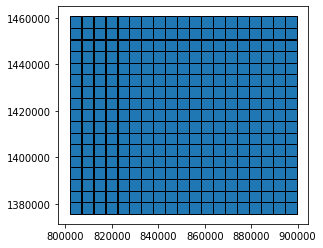

In [8]:
df = sdg.regular_grid(5000, 5000)
print(f'Created {len(df)} samples')

df.plot(color=None, edgecolor='k')
df.head()

Similalry, you could create a dataframe with random samples. In this case you will need to speciy the number of samples in addition to the width and height dimensions of each sample in the native resolution of the SDG source raster. For example, here we created 323 samples as in the regular grid with equal dimnsions of 5000 meters.  

Created 323 samples


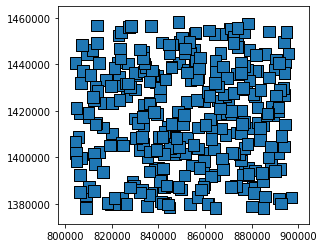

In [10]:
df_rand = sdg.random_grid(5000, 5000, 323)

print(f'Created {len(df_rand)} samples')
df_rand.plot(color=None, edgecolor='k')


### 2.3 Callback functions 

The SDG class includes a callback mechanism to enable on-the-fly data augmentation. Callback can be any function that accepts a numpy array and returns a numpy array. However, you should ensure that the array shape remains consistent as the callback function output will likely be combined with other data, for example raw raster or label data,before sending it to the model as a single array. 

## 3. A practical example: Preprocessing Digital Elevation Models (DEM) 

We will start with a simple example of preparing Digital Elevation Models (DEM) for a landscpe morphological classification using a deep learning model. Here we have two input rasters (1) an elevation raster that we want to segment and (2) a label raster that shows the locations of a sample of the geographic units. The model produce a binary classification of positions on the landscape that are associated with grass waterways, which are commonly found surface hydrology features in agriculture fields.

The DEM raster, below, shows the height of every pixel over the Lake Bloomington Watershed area in central Illinois, where the dark pixels are regions with lower elevation.

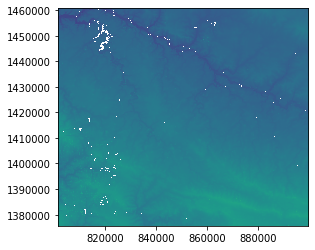

In [12]:
import rasterio 
from rasterio.plot import show

dem_path = '/home/kv64/main/projects/proj_keras_spatial/data/mclean_roi.tif'

dem = rasterio.open(dem_path)
show(dem)

The label is a binary raster where light color pixels indicate the loactions of the feature of interest (grass waterways). You should notice that the features are concentrated within the boundaries of the Lake Bloomington Watershed. Areas outside of the watershed were not manually lablled, therefore we can not use them to train the model, and these areas must be excluded from the training and evaluation samples set. It should be also noticed that the geographic projection and spatial resolution of DEM and label rasters are different, but both rasters' units are in meters. 

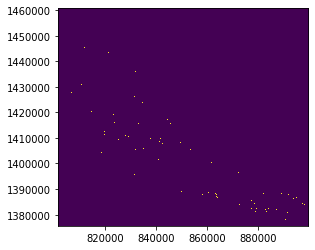

In [13]:
label_path = '/home/kv64/main/projects/proj_keras_spatial/data/cl1.tif'

label = rasterio.open(label_path)
show(label)

### 3.1 Managing sample space 

One of the advantages of using a GeoDataFrame to store the boundaries of the samples is easy filtering and selecting samples to feed to the deep learning model. You can select a subset of samples either by applying a spatial selection criterion (intersection, within, etc.) with an external vector file or by applying a database query on the sample attributes columns. We will discuss how to create sample attributes columns later, but let us start with selecting samples based on spatial relationships. 

#### Selecting samples within an area of interest

Selecting samples based on spatial relationships is useful in the case that the study area has an irregular boundary, or as we mentioned earlier, some areas might have not been included in the manual labeling. Keras spatial inherited the spatial queries from geopandas, therefore Keras Spatial spports any complicated spatial selection criteria on the samples objects.

We will use a vector shapfile as a mask and select only the samples that intesects Lake Bloomington watershed boundaries. Notice that you could use a more complicated spatial relationship as a selection criteria, such as selecting samples that falls within, touch, or do not intersect with the boundaries of a vector object. 

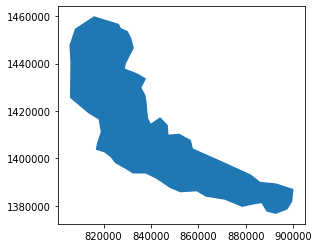

In [8]:
#Read and plot a vector mask 

file = '/home/kv64/main/projects/proj_keras_spatial/data/lake_watershed/lakeb_watershed.shp'
mask = gpd.read_file(file)
mask.plot()

Here we select all the samples that intersects our watershed. Notice that the first and only object (watershed) was selected to perform the intersection process.  

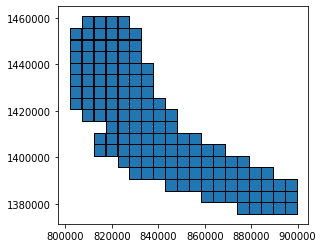

In [11]:
polygon = mask.geometry[0] # define which polygon you want 0 is the first and only polygon
subset = df[df.intersects(polygon)] 
subset.plot(color=None, edgecolor='k')

#### Adding samples' attributes columns

Upon creating a geo-dataframe for samples, it will contain a single column with the bounding box (geometry) of each sample. A powerful concept in Keras Spatial is setting selection criteria based on sample attributes. This capability comes handy when quantifying class imbalance in training samples, or the geographic bias of samples towards an area with specific attributes, such as specific soil type, average elevation, etc. Once these attributes are added to your geo-dataframe, selecting samples will be a matter of applying conditional query based on column values as in slicing any dataframe. The question is how to add the samples attributes to the samples geo-dataframe?

An easy way to solve this problem is to use the Spatial Data Generator to extract the attributes from an external raster source and added it as a column in your samples' geo-dataframe. Thanks to the flexible design of Keras Spatial, which allows using SDG in different ways. In the following example, the count of labels pixels will be extracted from the label raster and added as a second column named features in the samples' geo-dataframe. Notice that we defined a batch size of one to grantee a one to one correspondence with every single sample.              


,geometry,features,elevation
14,"POLYGON ((879066.1111111111 1375599.99, 879066...",0.0,941.049988
15,"POLYGON ((884228.3333333334 1375599.99, 884228...",0.0,887.140015
16,"POLYGON ((889390.5555555555 1375599.99, 889390...",16.0,919.309998
17,"POLYGON ((894552.7777777778 1375599.99, 894552...",222.0,918.400024
18,"POLYGON ((899715 1375599.99, 899715 1380599.99...",72.0,919.729980


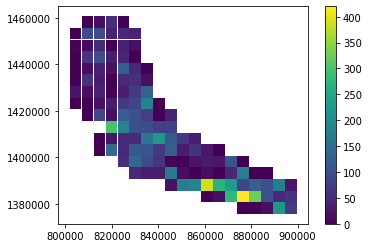

In [27]:
# define label raster as a source raster 
label_path = '/home/kv64/main/projects/proj_keras_spatial/data/cl1.tif'
    
lsdg = SpatialDataGenerator() 
lsdg.source = label_path
input_size = (128,128)

subset.loc[:,'features'] = [ ( np.sum(np.where(arr==1, 0, arr) )) 
                    for arr in lsdg.flow_from_dataframe (subset , *input_size, batch_size =1)]


subset.plot(column='features', legend=True)

subset.head(5)


The same process could be repeated to add more attributes from other raster files. For example, in the following cell, we added the average elevation of each sample as a second attribute column. Notice that we also used an SDG with a batch size of one to generate the elevation column. However, we defined the SDG source as the DEM raster in this case. Remarkably, we can add attributes from vector layers as well. For example, a land cover layer could be used to estimate the dominant land cover type of each sample.

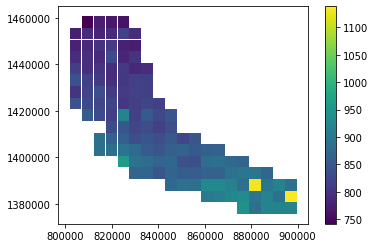

In [30]:
dem_path = '/home/kv64/main/projects/proj_nrcs/original_dem_images/mclean_roi.tif'
rsdg = SpatialDataGenerator(dem_path)

subset.loc[:,'elevation'] = [(np.max(arr)) for arr in rsdg.flow_from_dataframe (subset, 128, 128, batch_size=1)]
subset.head(10)

subset.plot(column='elevation', legend=True)

### 3.2 Estimating global statistics 

One of the major challenges that you could face when using data generators is estimating global statistics for the entire samples set. For example, in the case that you want to normalize each sample using the global maximum and minimum of the entire data set. This process is difficult because of the piecewise strategy of the data generator to load a batch of samples at a time. Although this strategy uses memory efficiently, it makes the retrieval of global statistics difficult.  

We adopted a two-step solution to solve this problem in Keras Spatial. In the first step, we estimate the local statistical attributes for each sample. In the second run, the global attributes of all samples are estimated from the sample dataframe attribute columns. In the following example, we estimate the global maximum and minimum elevation by first adding two columns with the maximum and minimum elevation for each sample (local statistics) as we demonstrated before. Once the minimum and maximum columns are added to the datafarme, we can estimate the global maximum and minimum directly from the dataframe.

In [ ]:
subset['maxelv'] = [(np.max(arr)) for arr in rsdg.flow_from_dataframe (subset, 128, 128, batch_size=1)]
subset['minelv'] = [(np.min(arr)) for arr in rsdg.flow_from_dataframe (subset, 128, 128, batch_size=1)]

print(np.max(subset['maxelv']), (np.min(subset['minelv'])))

subset.head(5)

### 3.3 Sample normalization using callback functions 

Here we have an example of this technique, where the sample set min/max is passed to a normalization callback. Notice that we used a predefined normalization function, which requires an input array and a global minimum and maximum value. You could also write your function and implement it in the same described method.    

In [12]:
from keras_spatial.augmentation import normalize

sdg.add_preprocess_callback('elvnorm', normalize, min(subset.minelv), max(subset.maxelv))
print(sdg.preprocess)
gen = sdg.flow_from_dataframe(subset, 128, 128, batch_size=1)
arr = next(gen)

imgplot = plt.imshow(arr[0,:,:,0], cmap='viridis')
plt.colorbar()

In [14]:
# should we add an example of the terrain derivatives 

# In order to enhance the accuracy of the segmentation model, we added five terrain derivatives 
# to provides information about the reltiave height at a single pixel with respect to the surrounding locations (pixels).

### 3.4 Feeding data directly to train a deep learning model 

After the sample dataframe is filtered and all the relevant samples are selected, then it can be used to feed data in a stepwise fashion to the deep learning model. In the following example, we created two spatial data generators with two different sources, the DEM and labels. Notice that the data frame is generated once and used for both SDGs. Similarly, the input dimensions are defined for the label generator and copied in the second DEM data generator. It is very important to use the same geo-dataframe and maintain consistent dimensions to ensure that data and labels are matching each other before they are zipped and feed together to train the deep learning model.    

In [ ]:
# example of Feeding samples to a DL model 

from keras_spatial import SpatialDataGenerator

labels = SpatialDataGenerator()
labels.source = '/path/to/labels.tif'
labels.width, labels.height = 128, 128
df = labels.regular_grid(200,200)

samples = SpatialDataGenerator()
samples.source = 'https://server.com/files/data.tif'
samples.width, samples.height = labels.width, label.height

train_gen = zip(labels.flow_from_dataframe(df), patches.flow_from_dataframe(df))
model(train_gen)

## 4. Accounting for Samples Bias using Kears Spatial 

AI bias in the geospatial context is usually attributed to applying deep learning models to geospatial data with very different statistical characteristics compared to the data that were used to train the models. Geospatial data has a unique spatial dependency which makes their statistical property vary significantly across space. Therefore, it is often found that models trained in one location might not generalize well beyond the initial study area. 

Keras Spatial solves this problem by providing means to quantify the samples' statistical distribution. In the following simple example, we examine the statistical distribution of samples across two attributes, average elevation, and density of labels pixels. It is clear that the samples came from a single distribution with an exception to two samples. For example, you could also estimate the degree of concordance between the training and prediction sets to ensure the quality of prediction. In this case, you could easily filter the prediction datasets before feeding them to the model to ensure that they fit the expected characteristics range of the training dataset.

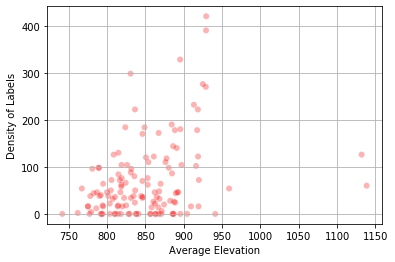

In [37]:
fig, ax = plt.subplots()

x = subset['elevation']
y = subset['features']

ax.scatter(x, y, c='red',  alpha=0.3, edgecolors='none')
ax.set_xlabel('Average Elevation')
ax.set_ylabel('Density of Labels')
ax.grid(True)

plt.show()

## 5. Conclusion

We introduced Keras Spatial that provides a preprocessing module tailored for remote sensing and geospatial data. Keras Spatial reduces the friction in handling geospatial data by providing loosely coupled preprocessing capabilities to retrieve and transform data on-the-fly. You have learned the advantages of using Keras Spatial over more traditional Ad-hoc pipelines in (1) preparing your samples set in a reproducible way and (2) controlling the sample space and hence avoiding issues such as bias and class imbalance during training. Please refer to [(Soliman and Terstriep, 2019)](https://dl.acm.org/doi/10.1145/3356471.3365240) for more information about Keras Spatial. 

## Acknowledgment

This research is based in part upon work supported by Illinois Natural Resources Conservation Service, Illinois State Geological Survey, and the Illinois State Water Survey.